In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.datasets import fashion_mnist


In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Normalize from from 0 to 255 to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
# Convert 2D images (28x28 pixels) into 1D vectors (784 values)
train_flat = train_images.reshape(len(train_images), -1)  # shape: (60000, 784)
test_flat = test_images.reshape(len(test_images), -1)    # shape: (10000, 784)

In [8]:
# Check the Result
print("Shape before flattening:", train_images.shape)  # (60000, 28, 28)
print("Shape after flattening:", train_flat.shape)     # (60000, 784)

print("Pixel range:", train_images.min(), "to", train_images.max())

Shape before flattening: (60000, 28, 28)
Shape after flattening: (60000, 784)
Pixel range: 0.0 to 1.0


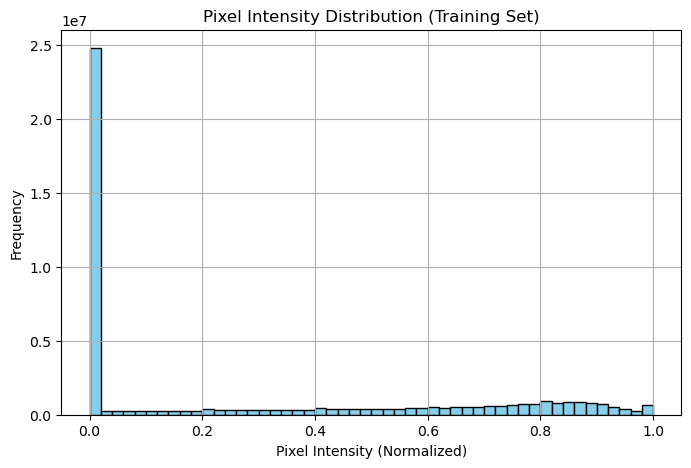

In [ ]:
# Flatten all training pixels into a 1D array
all_pixels = train_images.flatten()

# Plot histogram of pixel values to understand how grayscale intensities (0 to 255 → now scaled 0 to 1) are distributed across the dataset.
plt.figure(figsize=(8, 5))
plt.hist(all_pixels, bins=50, color='skyblue', edgecolor='black')
plt.title("Pixel Intensity Distribution (Training Set)")
plt.xlabel("Pixel Intensity (Normalized)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

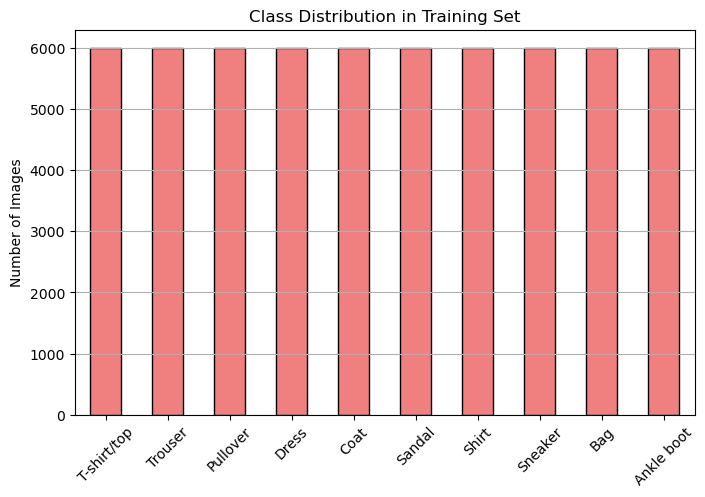

In [15]:
# Class names mapping
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a DataFrame for counts
label_counts = pd.Series(train_labels).value_counts().sort_index()
label_counts.index = class_names

# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [52]:
print("Missing values in trining data:", np.isnan(train_images).sum())
print("max value ",train_images.max())
print("min value",train_images.min() )

Missing values in trining data: 0
max value  1.0
min value 0.0


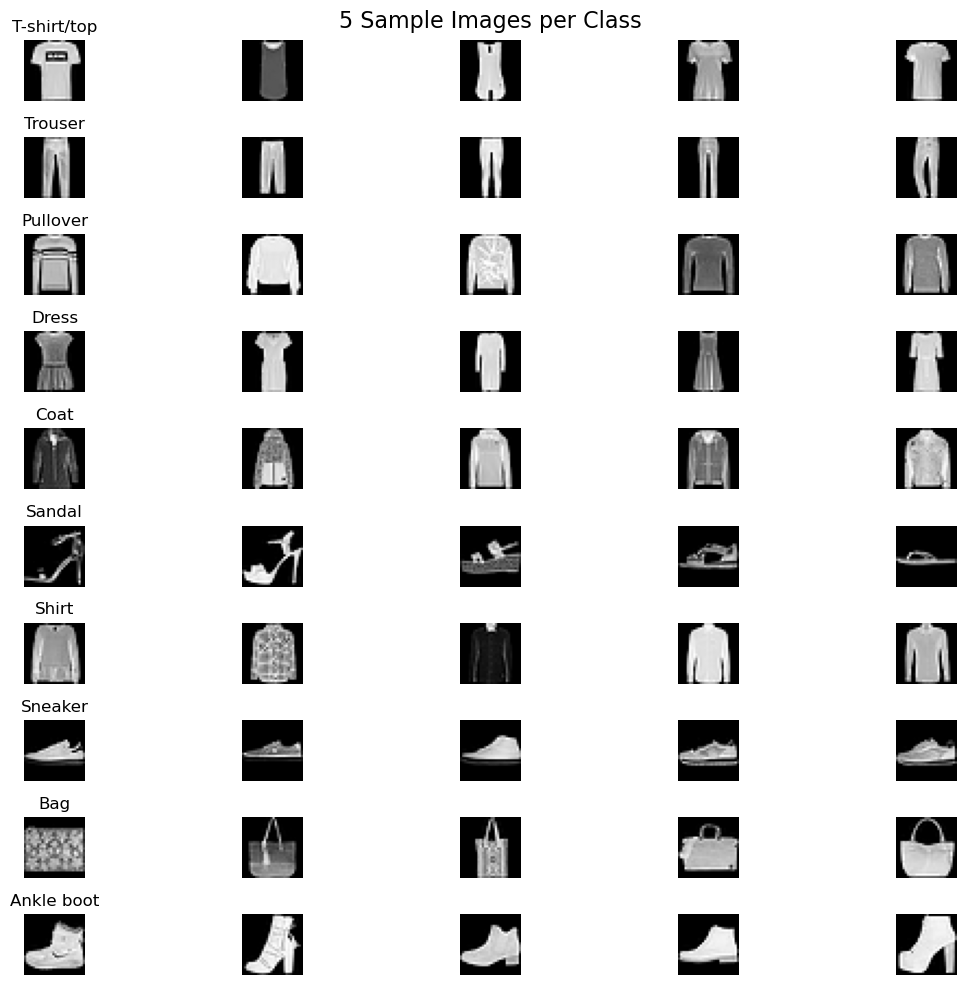

In [17]:
# Plot 5 samples per class
plt.figure(figsize=(12, 10))

for label in range(10):
    # Get indexes of images with this label
    idxs = np.where(train_labels == label)[0][:5]
    
    for i, idx in enumerate(idxs):
        plt_idx = label * 5 + i + 1
        plt.subplot(10, 5, plt_idx)
        plt.imshow(train_images[idx], cmap="gray")
        plt.axis("off")
        
        if i == 0:
            plt.title(class_names[label])

plt.suptitle("5 Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flattened data assumed from earlier step
# train_flat shape: (60000, 784)

# Apply PCA without specifying n_components (keep all to analyze variance)
pca = PCA()
pca.fit(train_flat)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

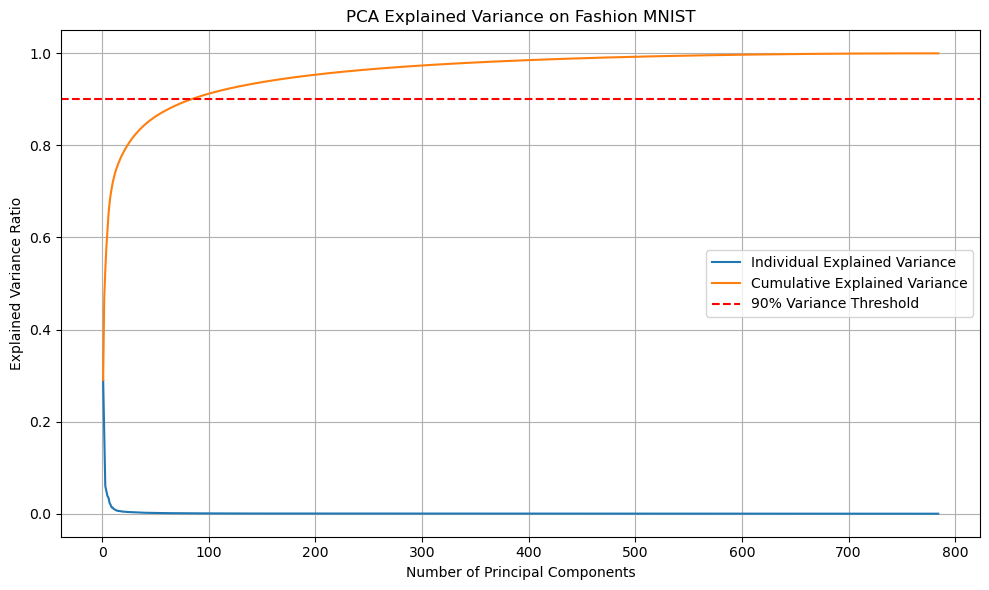

In [19]:
plt.figure(figsize=(10, 6))

# Explained variance per component
plt.plot(range(1, len(explained_variance) + 1), explained_variance, label="Individual Explained Variance")

# Cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, label="Cumulative Explained Variance")

plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.title("PCA Explained Variance on Fashion MNIST")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error

def reconstruct_and_evaluate(train_flat, n_components_list):
    mse_results = {}
    reconstructions = {}

    for n in n_components_list:
        # Fit PCA and transform
        pca = PCA(n_components=n)
        train_reduced = pca.fit_transform(train_flat)
        
        # Reconstruct images
        train_reconstructed = pca.inverse_transform(train_reduced)
        
        # Calculate MSE between original and reconstructed
        mse = mean_squared_error(train_flat, train_reconstructed)
        mse_results[n] = mse
        reconstructions[n] = train_reconstructed

        print(f"{n} components → MSE: {mse:.5f}")

    return mse_results, reconstructions

n_components_list = [10, 50, 100]
mse_results, reconstructions = reconstruct_and_evaluate(train_flat, n_components_list)



10 components → MSE: 0.02437
50 components → MSE: 0.01195
100 components → MSE: 0.00763


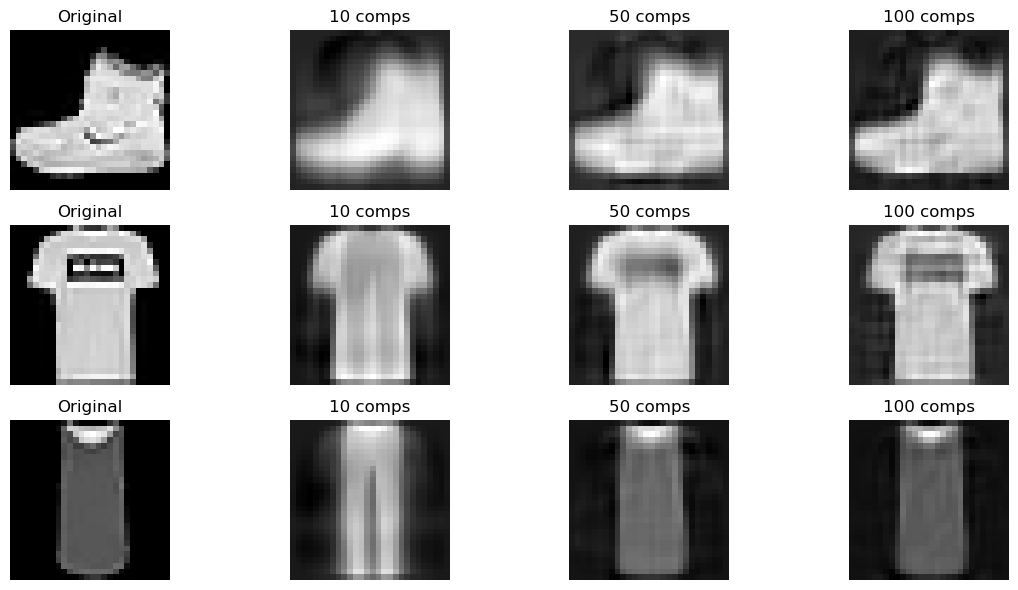

In [23]:
import matplotlib.pyplot as plt

def show_reconstruction_comparison(originals, reconstructions, indices=[0, 1, 2]):
    plt.figure(figsize=(12, len(indices) * 2))

    for row, idx in enumerate(indices):
        # Original
        plt.subplot(len(indices), len(reconstructions) + 1, row * (len(reconstructions) + 1) + 1)
        plt.imshow(originals[idx].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructions
        for col, n in enumerate(sorted(reconstructions.keys())):
            plt.subplot(len(indices), len(reconstructions) + 1, row * (len(reconstructions) + 1) + 2 + col)
            plt.imshow(reconstructions[n][idx].reshape(28, 28), cmap='gray')
            plt.title(f"{n} comps")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_reconstruction_comparison(train_flat, reconstructions)


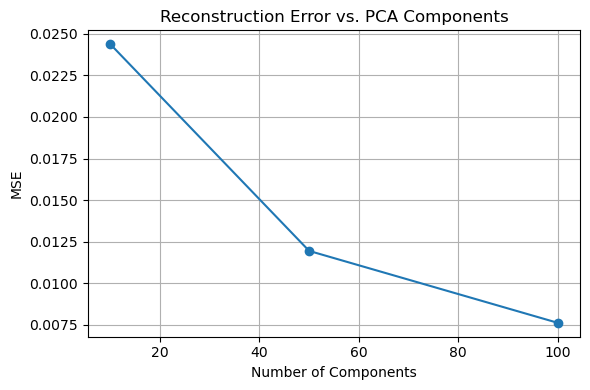

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(mse_results.keys(), mse_results.values(), marker='o')
plt.title("Reconstruction Error vs. PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()


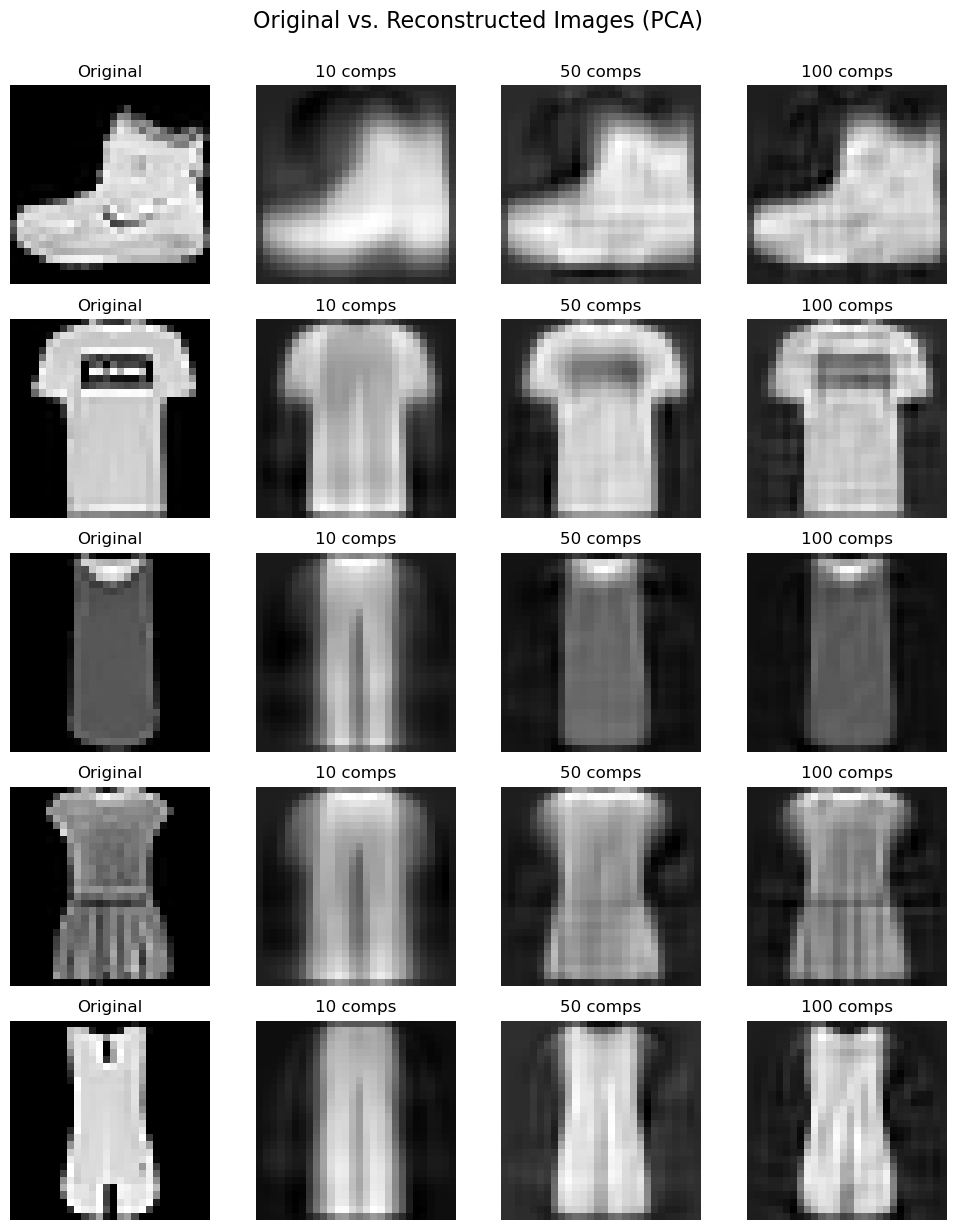

In [25]:
import matplotlib.pyplot as plt

def show_reconstruction_comparison(originals, reconstructions, indices=[0, 1, 2, 3, 4]):
    num_examples = len(indices)
    num_versions = len(reconstructions) + 1  # +1 for original

    plt.figure(figsize=(num_versions * 2.5, num_examples * 2.5))

    for row, idx in enumerate(indices):
        # Original image
        plt.subplot(num_examples, num_versions, row * num_versions + 1)
        plt.imshow(originals[idx].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed versions
        for col, n in enumerate(sorted(reconstructions.keys())):
            plt.subplot(num_examples, num_versions, row * num_versions + 2 + col)
            plt.imshow(reconstructions[n][idx].reshape(28, 28), cmap='gray')
            plt.title(f"{n} comps")
            plt.axis('off')

    plt.suptitle("Original vs. Reconstructed Images (PCA)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Show side-by-side comparison
show_reconstruction_comparison(train_flat, reconstructions)


In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

def reconstruct_with_svd(train_flat, n_components_list):
    mse_results = {}
    reconstructions = {}

    for n in n_components_list:
        svd = TruncatedSVD(n_components=n)
        reduced = svd.fit_transform(train_flat)
        reconstructed = svd.inverse_transform(reduced)

        mse = mean_squared_error(train_flat, reconstructed)
        mse_results[n] = mse
        reconstructions[n] = reconstructed

        print(f"SVD - {n} components → MSE: {mse:.5f}")

    return mse_results, reconstructions

n_components_list = [10, 50, 100]
svd_mse, svd_recon = reconstruct_with_svd(train_flat, n_components_list)



SVD - 10 components → MSE: 0.02449
SVD - 50 components → MSE: 0.01197
SVD - 100 components → MSE: 0.00764


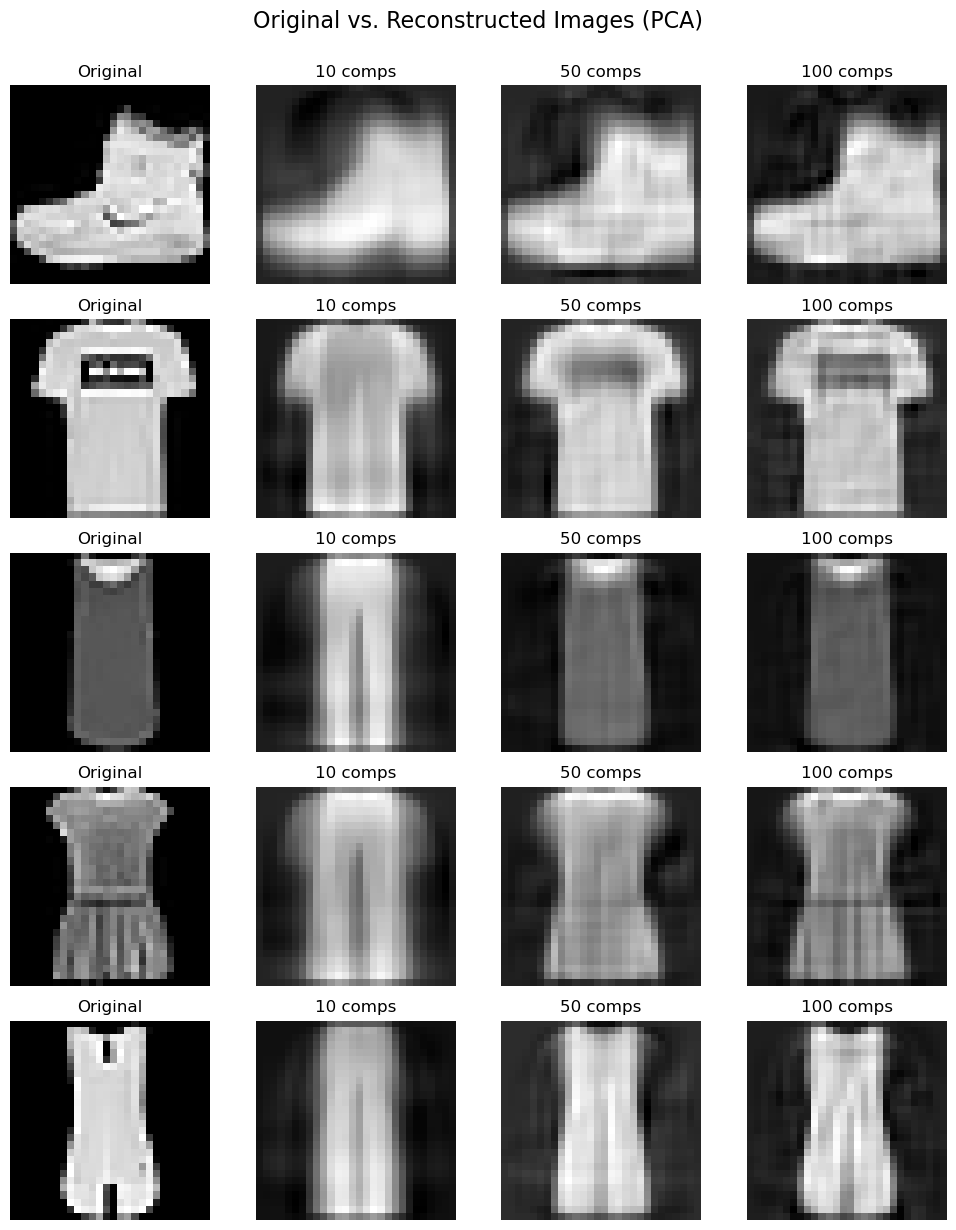

In [28]:
show_reconstruction_comparison(train_flat, svd_recon)


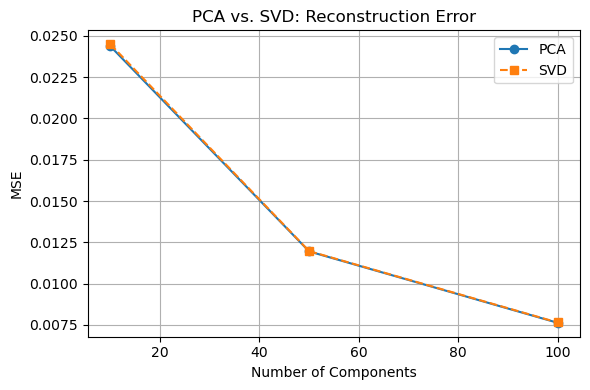

In [29]:
plt.figure(figsize=(6, 4))
plt.plot(list(mse_results.keys()), list(mse_results.values()), marker='o', label='PCA')
plt.plot(list(svd_mse.keys()), list(svd_mse.values()), marker='s', label='SVD', linestyle='--')
plt.title("PCA vs. SVD: Reconstruction Error")
plt.xlabel("Number of Components")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.decomposition import PCA

# Reduce to 50 dimensions for clustering
pca_50 = PCA(n_components=50)
train_reduced = pca_50.fit_transform(train_flat)


In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = [8, 10, 12]
kmeans_results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_reduced)
    
    sil_score = silhouette_score(train_reduced, labels)
    inertia = kmeans.inertia_
    
    kmeans_results[k] = {
        'labels': labels,
        'silhouette': sil_score,
        'inertia': inertia
    }
    
    print(f"K={k}: Silhouette={sil_score:.4f}, Inertia={inertia:.0f}")


K=8: Silhouette=0.1984, Inertia=1493612
K=10: Silhouette=0.1726, Inertia=1375636
K=12: Silhouette=0.1821, Inertia=1286560


In [37]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

dbscan_configs = [(3, 5), (5, 5), (5, 10)]
dbscan_results = {}

for eps, min_samples in dbscan_configs:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(train_reduced)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Compute silhouette score only if we have 2 or more clusters
    if n_clusters >= 2:
        mask = labels != -1
        if mask.any():
            sil_score = silhouette_score(train_reduced[mask], labels[mask])
        else:
            sil_score = -1
    else:
        sil_score = -1

    dbscan_results[(eps, min_samples)] = {
        'labels': labels,
        'silhouette': sil_score,
        'n_clusters': n_clusters
    }

    print(f"DBSCAN (eps={eps}, min_samples={min_samples}) → Clusters={n_clusters}, Silhouette={sil_score:.4f}")


DBSCAN (eps=3, min_samples=5) → Clusters=19, Silhouette=-0.3066
DBSCAN (eps=5, min_samples=5) → Clusters=1, Silhouette=-1.0000
DBSCAN (eps=5, min_samples=10) → Clusters=1, Silhouette=-1.0000


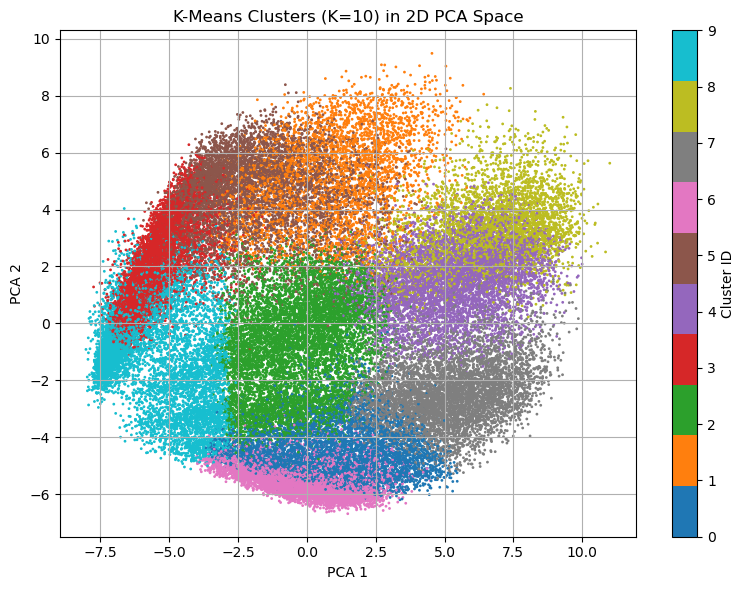

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for plotting
pca_2d = PCA(n_components=2)
train_2d = pca_2d.fit_transform(train_flat)

# Use best K from your K-Means (e.g., K=10)
best_k = 10
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(train_reduced)  # Use earlier 50D reduction

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(train_2d[:, 0], train_2d[:, 1], c=kmeans_labels, cmap='tab10', s=1)
plt.title(f"K-Means Clusters (K={best_k}) in 2D PCA Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.tight_layout()
plt.show()


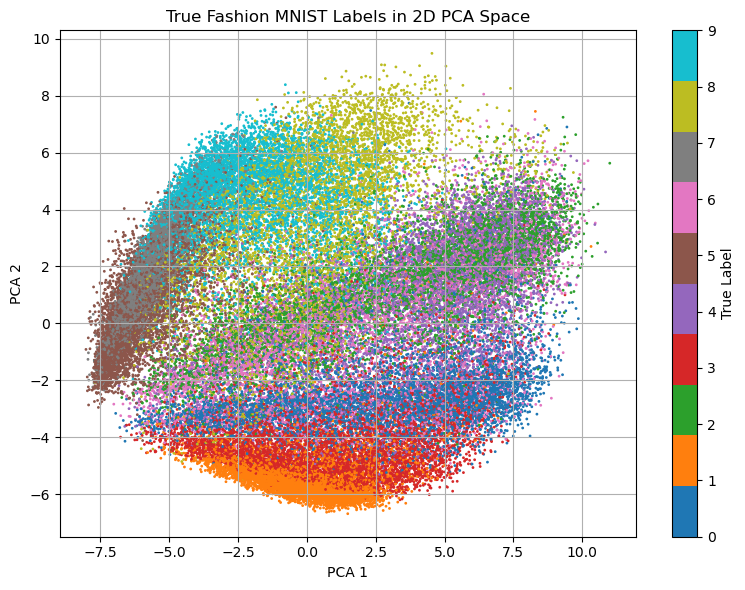

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(train_2d[:, 0], train_2d[:, 1], c=train_labels, cmap='tab10', s=1)
plt.title("True Fashion MNIST Labels in 2D PCA Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='True Label')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# Cross-tab of K-Means clusters vs true labels
cluster_comparison = pd.crosstab(train_labels, kmeans_labels,
                                 rownames=['True Label'], colnames=['Cluster'])
cluster_comparison

Cluster,0,1,2,3,4,5,6,7,8,9
True Label,,,,,,,,,,
0,419,32,1481,5,43,0,6,3285,141,588
1,271,3,127,0,44,0,5193,179,27,156
2,14,37,1661,2,1769,0,1,80,1937,499
3,3923,7,483,0,57,0,38,961,15,516
4,305,27,902,0,2979,0,9,547,983,248
5,7,11,59,1500,0,498,0,0,0,3925
6,175,73,1967,7,1129,2,3,966,933,745
7,0,2,1,5097,0,284,0,0,0,616
8,80,3532,1288,389,53,9,3,24,242,380
